# Dynamics Simulations

There are weird things going on with the simulator that I must check out.

In [449]:
from bioreaction.simulation.simfuncs.basic_de import bioreaction_sim_expanded
from bioreaction.model.data_tools import construct_model_fromnames
from bioreaction.simulation.basic_sim import convert_model

import diffrax as dfx
import jax
import pandas as pd
import numpy as np
from scipy import integrate
from functools import partial
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
jax.config.update('jax_platform_name', 'cpu')

# from src.utils.misc.units import per_mol_to_per_molecule
def per_mol_to_per_molecule(per_mol):
    """ Translate a value from the unit of per moles to per molecules.
    The number of M of mRNA in a cell was calculated using the average 
    number of mRNA in an E. coli cell (100 molecules) and the average volume of an E.
    coli cell (1.1e-15 L) to give ca. 1 molecule ~ 1.50958097 nM ~ 1.50958097e-9 M"""
    # 1/mol to 1/molecule
    # return np.divide(jmol, SCIENTIFIC['mole'])
    return np.multiply(per_mol, 1.50958097/np.power(10, 9))


In [450]:
num_species = 3
input_species_idx = 0

Keq = np.array(
    [[1, 1, 1],
     [1, 1, 1],
     [1, 1, 1]]
)
# From src/utils/common/configs/RNA_circuit/molecular_params.json
a = np.ones(3) * 0.08333        # Creation rate
d = np.ones(3) * 0.0008333      # Degradation rate
ka = np.ones_like(Keq) * per_mol_to_per_molecule(1000000)   # Association rate
kd = ka/Keq     # Dissociation rate

model = construct_model_fromnames([str(i) for i in range(num_species)])
model.species = model.species[-num_species:] + model.species[:-num_species]


def update_model_rates(model, a=None, d=None, ka=None, kd=None):
    for i, r in enumerate(model.reactions):
        if not r.input:  # 0 -> RNA
            if a is not None:
                model.reactions[i].forward_rate = a[model.species.index(
                    r.output[0])]
                model.reactions[i].reverse_rate = 0
        elif not r.output:  # RNA -> 0
            if d is not None:
                model.reactions[i].forward_rate = d[model.species.index(
                    r.input[0])]
                model.reactions[i].reverse_rate = 0
        else:
            if ka is not None:
                model.reactions[i].forward_rate = ka[model.species.index(r.input[0]),
                                                     model.species.index(r.input[1])]
            if kd is not None:
                model.reactions[i].reverse_rate = kd[model.species.index(r.input[0]),
                                                     model.species.index(r.input[1])]
    return model


def make_params(model, scale_rates=True):
    sim_model = convert_model(model)

    if scale_rates:
        m = np.max([sim_model.forward_rates.max(), sim_model.reverse_rates.max()])
    else:
        m = 1
    inputs = sim_model.inputs
    outputs = sim_model.outputs
    forward_rates = sim_model.forward_rates/m
    reverse_rates = sim_model.reverse_rates/m
    # batch = 40
    # reverse_rates = reverse_rates * \
    #     np.ones((batch, sim_model.reverse_rates.shape[0]))
    # reverse_rates = reverse_rates * np.random.random(reverse_rates.shape)
    return inputs, outputs, forward_rates, reverse_rates, m


model = update_model_rates(model, a, d, ka, kd)
inputs, outputs, forward_rates, reverse_rates, m1 = make_params(model)

a_sig = a * 1
a_sig[input_species_idx] = a_sig[input_species_idx] * 2
new_model = update_model_rates(model, a, d, ka, kd)
# y0 = np.concatenate(
#     [np.array([1.0, 1.0, 1.0]), np.zeros(len(model.species[num_species:]))])
y0 = np.zeros(len(model.species))
t0 = 0.0
t1 = 500.0
dt0 = 0.1
tmax = int(t1/2/dt0+1e4)
# tmax = 16**7
signal = None
signal_onehot = None
solver = dfx.Tsit5()
saveat = dfx.SaveAt(
    t0=True, t1=True, steps=True)

In [21]:



def bioreaction_sim_dfx_expanded(y0, t0, t1, dt0,
                                 inputs, outputs, forward_rates, reverse_rates,
                                 signal, signal_onehot: np.ndarray,
                                 solver=dfx.Tsit5(),
                                 saveat=dfx.SaveAt(
                                     t0=True, t1=True, steps=True),
                                 max_steps=16**5):
    term = dfx.ODETerm(
        partial(bioreaction_sim_expanded,
                inputs=inputs, outputs=outputs,
                forward_rates=forward_rates, reverse_rates=reverse_rates
                )
    )
    return dfx.diffeqsolve(term, solver,
                           t0=t0, t1=t1, dt0=dt0,
                           y0=y0,
                           saveat=saveat, max_steps=max_steps,
                           stepsize_controller=dfx.PIDController(rtol=1e-3, atol=1e-6))  # 16**4)


x1 = bioreaction_sim_dfx_expanded(
    y0=y0,
    t0=0.0,
    t1=t1/2,
    dt0=dt0,
    inputs=inputs,
    outputs=outputs,
    forward_rates=forward_rates,
    reverse_rates=reverse_rates,
    signal=None,
    signal_onehot=None,
    solver=dfx.Tsit5(),
    saveat=dfx.SaveAt(
        t0=True, t1=True, steps=True),
    max_steps=tmax)
# reverse_rates=reverse_rates)

inputs, outputs, forward_rates, reverse_rates, m2 = make_params(new_model)


x2 = bioreaction_sim_dfx_expanded(
    y0=x1.ys[np.argmax(x1.ts >= np.inf)-1, :],
    t0=t1/2,
    t1=t1,
    dt0=dt0,
    inputs=inputs,
    outputs=outputs,
    forward_rates=forward_rates,
    reverse_rates=reverse_rates,
    signal=None,
    signal_onehot=None,
    solver=dfx.Tsit5(),
    saveat=dfx.SaveAt(
        t0=True, t1=True, steps=True),
    max_steps=tmax)


In [ ]:
xs1 = x1.ys[:x1.stats['num_accepted_steps'], :] #* m1
xs2 = x2.ys[:x2.stats['num_accepted_steps'], :] #* m2
ts1 = x1.ts[:x1.stats['num_accepted_steps'], :]
ts2 = x2.ts[:x2.stats['num_accepted_steps'], :]

In [ ]:
x1.ys.shape

(16777217, 9)

In [ ]:
x1.ys[np.argmax(x1.ts >= np.inf)-1, :]

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan],      dtype=float32, weak_type=True)

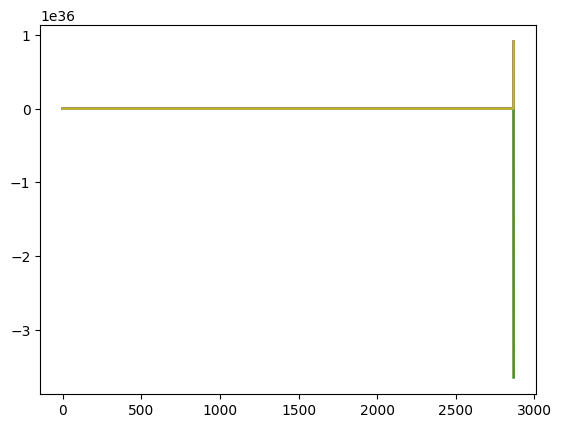

In [ ]:
plt.plot(np.concatenate([ts1, ts2]), np.concatenate([x1.ys*m, x2.ys*m]))

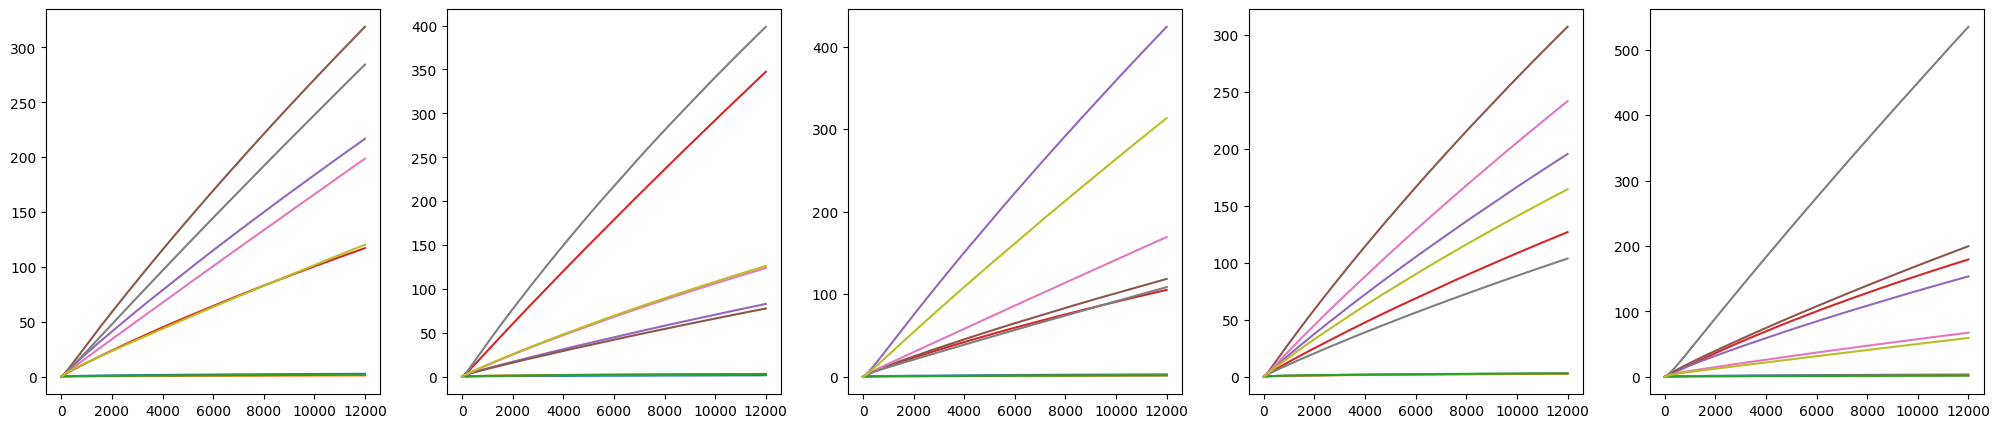

In [ ]:
# b = 5
# plt.figure(figsize=(5*b, 5))
# for i in range(b):
# # i = 1
#     ax = plt.subplot(1,b, i+1)
#     plt.plot(x.ts[i], (x.ys*m)[i])

## Compare to a stupid simple simulation

Text(0.5, 1.0, 'Output (y)')

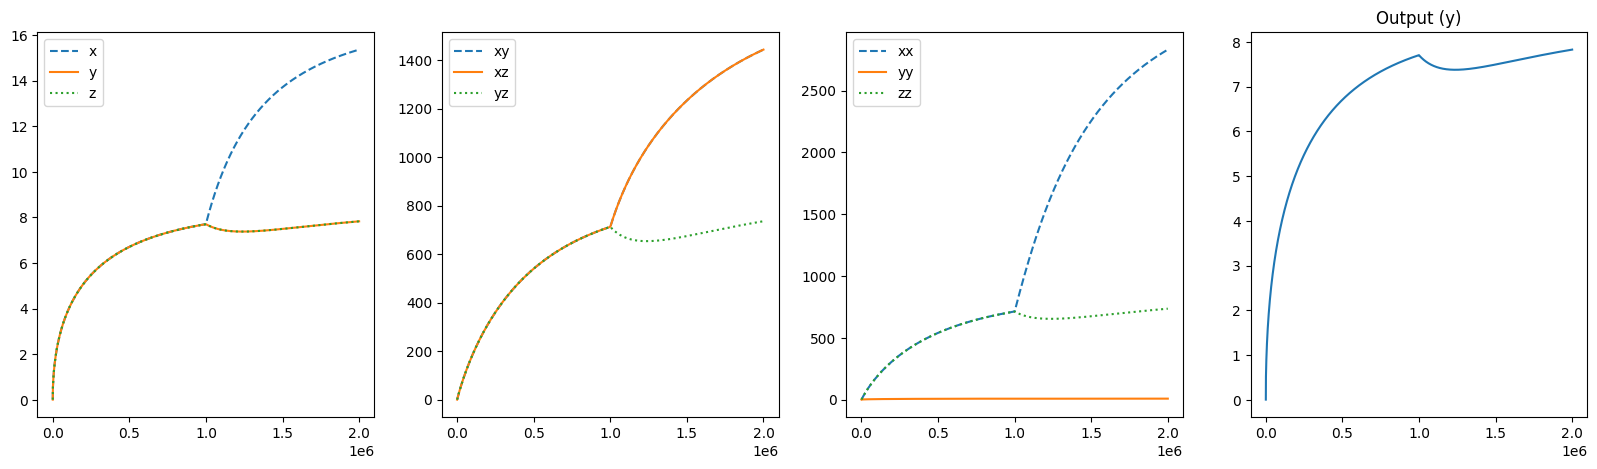

In [391]:
x = 0
y = 0
z = 0
xy = 0
xz = 0
yz = 0
xx = 0
yy = 0
zz = 0

x_res = []
y_res = []
z_res = []
xy_res = []
xz_res = []
yz_res = []
xx_res = []
yy_res = []
zz_res = []

# reverse rates
k00m = kd[0, 0]
k01m = kd[0, 1]
k02m = kd[0, 2]
k11m = kd[1, 1]
k12m = kd[1, 2]
k22m = kd[2, 2]

degx = 0.0008333
degy = 0.0008333
degz = 0.0008333

k00 = ka[0, 0]
k01 = ka[0, 1]
k02 = ka[0, 2]
k11 = ka[1, 1]
k12 = ka[1, 2]
k22 = ka[2, 2]

prodx = 0.08333
# prody=prodx*1.5
# prodz=prodx*0.8
prody = prodx
prodz = prodx

m = prodx

k00m, k01m, k02m, k11m, k12m, k22m, degx, degy, degz, k00, k01, k02, k11, k12, k22, prodx, prody, prodz = k00m/m, k01m/m,  k02m/m, k11m/m, k12m/m, k22m/m, degx/m, degy/m, degz/m, k00/m, k01/m, k02/m, k11/m, k12/m, k22/m, prodx/m, prody/m, prodz/m

dt = 0.1
n = 2000000
tmax = n*dt

for i in range(n):
    xnew = x+(prodx-degx*x-k01*x*y-k02*x*z+k01m *
              xy+k02m*xz - k00*x*x+k00m*xx)*dt
    ynew = y+(prody-degy*y-k01*x*y-k12*y*z+k01m *
              xy+k12m*yz - k11*y*y+k11m*yy)*dt
    znew = z+(prodz-degz*z-k02*x*z-k12*y*z+k02m *
              xz+k12m*yz - k22*z*z+k22m*zz)*dt

    xynew = xy+(k01*x*y-k01m*xy)*dt
    xznew = xz+(k02*x*z-k02m*xz)*dt
    yznew = yz+(k12*z*y-k12m*yz)*dt

    xxnew = xx+(k00*x*x-k00m*xx)*dt
    yynew = yy + (k11*y*y-k11m*yy)*dt
    zznew = yy + (k22*z*z-k22m*zz)*dt

    x = xnew 
    y = ynew 
    z = znew 
    xy = xynew 
    xz = xznew 
    yz = yznew 
    xx = xxnew 
    yy = yynew 
    zz = zznew 

    if i == int(n/2):
        prodx = prodx*2

    x_res.append(x * m)
    y_res.append(y * m)
    z_res.append(z * m)

    xy_res.append(xy * m)
    xz_res.append(xz * m)
    yz_res.append(yz * m)

    xx_res.append(xx * m)
    yy_res.append(yy * m)
    zz_res.append(zz * m)


plt.figure(figsize=(20, 5))

ax = plt.subplot(1, 4, 1)
plt.plot(x_res, '--')
plt.plot(y_res)
plt.plot(z_res, ":")
plt.legend(['x', 'y', 'z'])


ax = plt.subplot(1, 4, 2)
plt.plot(xy_res, '--')
plt.plot(xz_res)
plt.plot(yz_res, ":")
plt.legend(['xy', 'xz', 'yz'])

ax = plt.subplot(1, 4, 3)
plt.plot(xx_res, '--')
plt.plot(y_res)
plt.plot(zz_res, ":")
plt.legend(['xx', 'yy', 'zz'])


ax = plt.subplot(1, 4, 4)
plt.plot(y_res)
plt.title('Output (y)')


## Compare to dynamic sim but in for loop

Seems like the simple `for` loop version and the inner part of the solver do not match. The naive solution (red) converges quickly, while the concentrations of the bound together species in the solver (blue) continue to grow for much longer.

In [519]:
x=0 
y=0 
z=0 
xy=0 
xz=0 
yz=0 
xx=0 
yy=0 
zz=0 

k00m = kd[0, 0]
k01m = kd[0, 1]
k02m = kd[0, 2]
k11m = kd[1, 1]
k12m = kd[1, 2]
k22m = kd[2, 2]

degx = d[0]
degy = d[1]
degz = d[2]

k00 = ka[0, 0]
k01 = ka[0, 1]
k02 = ka[0, 2]
k11 = ka[1, 1]
k12 = ka[1, 2]
k22 = ka[2, 2]

prodx = a[0]
prody = prodx
prodz = prodx

inputs, outputs, forward_rates, reverse_rates, m1 = make_params(model, scale_rates=True)
# m1 = m1*2
k00m, k01m, k02m, k11m, k12m, k22m, degx, degy, degz, k00, k01, k02, k11, k12, k22, prodx, prody, prodz = k00m/m1, k01m/m1,  k02m/m1, k11m/m1, k12m/m1, k22m/m1, degx/m1, degy/m1, degz/m1, k00/m1, k01/m1, k02/m1, k11/m1, k12/m1, k22/m1, prodx/m1, prody/m1, prodz/m1

spec_conc = y0


In [520]:
tt = 2000000
spec_all1 = np.zeros((tt, len(model.species)))
spec_all2 = np.zeros((tt, len(model.species)))
outin_abs = np.nan_to_num((outputs - inputs) / np.abs((outputs - inputs) ))

for i in range(n):
    # Solver
    concentration_factors_in = np.prod(
        np.power(spec_conc, (inputs)), axis=1)
    concentration_factors_out = np.prod(
        np.power(spec_conc, (outputs)), axis=1)
    forward_delta = concentration_factors_in * forward_rates
    reverse_delta = concentration_factors_out * reverse_rates
    spec_conc += (forward_delta - reverse_delta) @ outin_abs * dt0
    spec_all1[i] = spec_conc * m1

    # Naive
    xnew = x+(prodx-degx*x-k01*x*y-k02*x*z+k01m *
              xy+k02m*xz - k00*x*x+k00m*xx)*dt
    ynew = y+(prody-degy*y-k01*x*y-k12*y*z+k01m *
              xy+k12m*yz - k11*y*y+k11m*yy)*dt
    znew = z+(prodz-degz*z-k02*x*z-k12*y*z+k02m *
              xz+k12m*yz - k22*z*z+k22m*zz)*dt

    xynew = xy+(k01*x*y-k01m*xy)*dt
    xznew = xz+(k02*x*z-k02m*xz)*dt
    yznew = yz+(k12*z*y-k12m*yz)*dt

    xxnew = xx+(k00*x*x-k00m*xx)*dt
    yynew = yy + (k11*y*y-k11m*yy)*dt
    zznew = yy + (k22*z*z-k22m*zz)*dt

    x = xnew 
    y = ynew 
    z = znew 
    xy = xynew 
    xz = xznew 
    yz = yznew 
    xx = xxnew 
    yy = yynew 
    zz = zznew 

    if i == int(n/2):
        prodx = prodx*2
        forward_rates = np.array(forward_rates)
        forward_rates[9] = forward_rates[9] * 2

    spec_all2[i] = np.array([[x, y, z, xx, xy, xz, yy, yz, zz]])*m1



Text(0.5, 1.0, 'Output (y)')

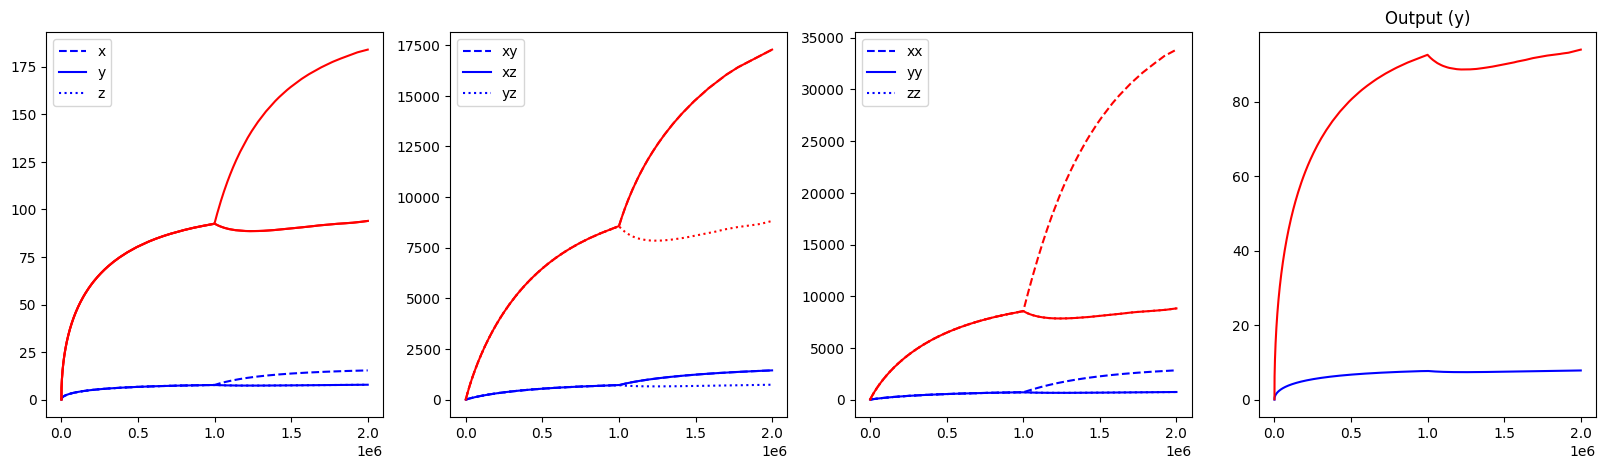

In [524]:

plt.figure(figsize=(20, 5))

ax = plt.subplot(1, 4, 1)
plt.plot(spec_all2[:, 0], 'b--')
plt.plot(spec_all2[:, 1], 'b')
plt.plot(spec_all2[:, 2], "b:")
plt.plot(spec_all1[:, :3], 'r')
plt.legend(['x', 'y', 'z'])


ax = plt.subplot(1, 4, 2)
plt.plot(spec_all2[:, 4], 'b--')
plt.plot(spec_all2[:, 5], 'b')
plt.plot(spec_all2[:, 7], "b:")
plt.plot(spec_all1[:, 4], 'r--')
plt.plot(spec_all1[:, 5], 'r')
plt.plot(spec_all1[:, 7], "r:")
plt.legend(['xy', 'xz', 'yz'])

ax = plt.subplot(1, 4, 3)
plt.plot(spec_all2[:, 3], 'b--')
plt.plot(spec_all2[:, 6], 'b')
plt.plot(spec_all2[:, 8], "b:")
plt.plot(spec_all1[:, 3], 'r--')
plt.plot(spec_all1[:, 6], 'r')
plt.plot(spec_all1[:, 8], "r:")
plt.legend(['xx', 'yy', 'zz'])


ax = plt.subplot(1, 4, 4)
plt.plot(spec_all2[:, 1], 'b')
plt.plot(spec_all1[:, 1], 'r')
plt.title('Output (y)')

Text(0.5, 1.0, 'Output (y)')

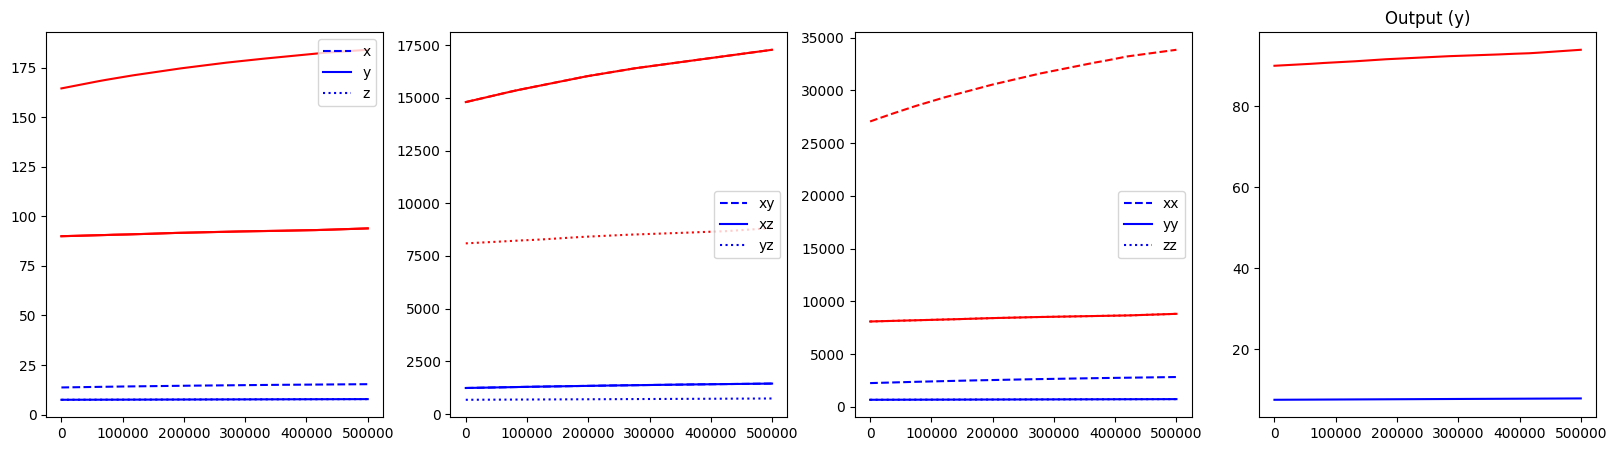

In [525]:

plt.figure(figsize=(20, 5))
t00 = int(1.5e6)

ax = plt.subplot(1, 4, 1)
plt.plot(spec_all2[t00:, 0], 'b--')
plt.plot(spec_all2[t00:, 1], 'b')
plt.plot(spec_all2[t00:, 2], "b:")
plt.plot(spec_all1[t00:, :3], 'r')
plt.legend(['x', 'y', 'z'])


ax = plt.subplot(1, 4, 2)
plt.plot(spec_all2[t00:, 4], 'b--')
plt.plot(spec_all2[t00:, 5], 'b')
plt.plot(spec_all2[t00:, 7], "b:")
plt.plot(spec_all1[t00:, 4], 'r--')
plt.plot(spec_all1[t00:, 5], 'r')
plt.plot(spec_all1[t00:, 7], "r:")
plt.legend(['xy', 'xz', 'yz'])

ax = plt.subplot(1, 4, 3)
plt.plot(spec_all2[t00:, 3], 'b--')
plt.plot(spec_all2[t00:, 6], 'b')
plt.plot(spec_all2[t00:, 8], "b:")
plt.plot(spec_all1[t00:, 3], 'r--')
plt.plot(spec_all1[t00:, 6], 'r')
plt.plot(spec_all1[t00:, 8], "r:")
plt.legend(['xx', 'yy', 'zz'])


ax = plt.subplot(1, 4, 4)
plt.plot(spec_all2[t00:, 1], 'b')
plt.plot(spec_all1[t00:, 1], 'r')
plt.title('Output (y)')

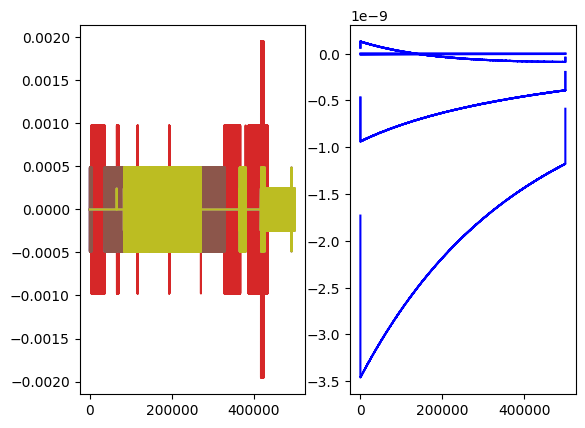

In [526]:
# plt.plot(np.gradient(spec_all1[t00:, 5])[1:] - np.gradient(spec_all1[t00:, 5])[:-1])
for i in range(len(model.species)):
    ax = plt.subplot(1,2,1)
    plt.plot(np.gradient(np.gradient(spec_all1[t00:, i])))
    ax = plt.subplot(1,2,2)
    plt.plot(np.gradient(np.gradient(spec_all2[t00:, i])), 'b')
# plt.plot(np.gradient(np.gradient(spec_all2[t00:, 3])))

In [461]:
tf = np.argmax(np.abs(spec_all1 - spec_all2) > 0.1, axis=0)
tf

array([ 1,  1,  1, 28, 28, 28, 28, 28, 28])

In [539]:

concentration_factors_in = np.prod(
    np.power(np.ones_like(spec_conc) * 3, (inputs)), axis=1)
concentration_factors_out = np.prod(
    np.power(np.ones_like(spec_conc) * 3, (outputs)), axis=1)
forward_delta = concentration_factors_in * forward_rates
reverse_delta = concentration_factors_out * reverse_rates

xd = (np.ones_like(spec_conc) * 3)[0] - forward_rates[0] * concentration_factors_in[0] 
xd = xd + forward_rates[9] # * concentration_factors_in[9]
xd = xd - forward_rates[3] * concentration_factors_in[3] + reverse_rates[3] * concentration_factors_out[3]
xd = xd - forward_rates[4] * concentration_factors_in[4] + reverse_rates[4] * concentration_factors_out[4]
xd = xd - forward_rates[5] * concentration_factors_in[5] + reverse_rates[5] * concentration_factors_out[5]
xd
3 + (forward_delta - reverse_delta) @ (outputs - inputs)

Array([4.535223 , 3.5352232, 3.5352232, 3.108694 , 3.108694 , 3.108694 ,
       3.108694 , 3.108694 , 3.108694 ], dtype=float32)

In [540]:
forward_delta - reverse_delta

Array([0.03      , 0.03      , 0.03      , 0.10869419, 0.10869419,
       0.10869419, 0.10869419, 0.10869419, 0.10869419, 2.        ,
       1.        , 1.        ], dtype=float32)

In [544]:
x, y, z, xx, xy, xz = 3, 3, 3, 3, 3, 3
x + (prodx - degx*x - 2*k00*x*x + 2 * k00m*xx - k01*x*y + k01m*xy - k02*x*z + k02m*xz)

4.535223327215178

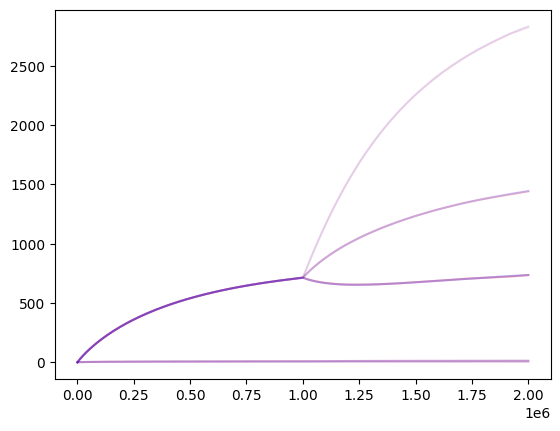

In [534]:
plt.plot(spec_all1 * m1, 'r', alpha=0.1)
plt.plot(spec_all2, 'b', alpha=0.1)

In [298]:

concentration_factors_in = np.prod(
    np.power(spec_all1[0], (inputs)), axis=1)
concentration_factors_out = np.prod(
    np.power(spec_all1[0], (outputs)), axis=1)
forward_delta = concentration_factors_in * forward_rates
reverse_delta = concentration_factors_out * reverse_rates

In [ ]:
plt.plot()

In [ ]:
t1m = 100
y = y0
y_all = np.zeros((int((t1m-t0)/dt0), len(model.species)))
inputs, outputs, forward_rates, reverse_rates, m1 = make_params(model)
m = m1
for i in range(int((t1m-t0)/dt0)):
    if i == int((t1m - t0)/dt0/2):
        inputs, outputs, forward_rates, reverse_rates, m2 = make_params(
            new_model)
        m = m2
    ynew = bioreaction_sim_expanded(i, y, args=None,
                                    inputs=inputs, outputs=outputs,
                                    forward_rates=forward_rates, reverse_rates=reverse_rates)
    y = y + ynew * dt0 * m
    y_all[i] = y
